In [ ]:
%pip install labelme tensorflow  opencv-python matplotlib albumentations

In [6]:
import os
import time
import uuid
import cv2 # type: ignore

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    # cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
pip install labelme

In [ ]:
!labelme

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf # type: ignore
import json
import numpy as np # type: ignore
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [11]:
images = tf.data.Dataset.list_files(os.path.join('data','images','*jpg'))

2024-09-13 14:47:49.873685: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-13 14:47:49.873725: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-13 14:47:49.873741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-13 14:47:49.873774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 14:47:49.873802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*jpg'

In [9]:
image_files_path = os.path.join('data', 'images', '*.jpg')

# Create a TensorFlow dataset with the image files
images = tf.data.Dataset.list_files(image_files_path)

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [1]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

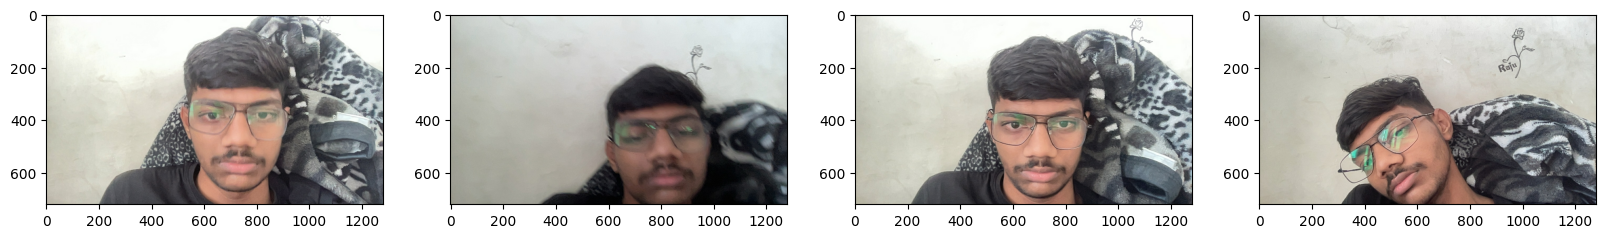

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [17]:
90*.7 # 63 to train

62.99999999999999

In [18]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [12]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

### 4.1 Setup Albumentations Transform Pipeline

In [13]:
import albumentations as alb

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [15]:
img = cv2.imread(os.path.join('data','train', 'images','1c271aa4-70d8-11ef-8135-a6f2f6925d9e.jpg'))

In [16]:
height, width = img.shape[:2]

In [17]:
with open(os.path.join('data', 'train', 'labels', '1c271aa4-70d8-11ef-8135-a6f2f6925d9e.json'), 'r') as f:
    label = json.load(f)

In [18]:
label['shapes'][0]['points']

[[462.28260869565224, 149.67391304347822],
 [931.8478260869565, 711.6304347826086]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [19]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [20]:
coords

[462.28260869565224, 149.67391304347822, 931.8478260869565, 711.6304347826086]

In [21]:
coords = list(np.divide(coords, [width, height, width, height]))

In [22]:
coords

[0.3611582880434783,
 0.20788043478260865,
 0.7280061141304348,
 0.9883756038647342]

### 4.4 Apply Augmentations and View Results

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented

In [25]:
augmented['bboxes']

[(0.0, 0.0, 0.6304830917874394, 1.0)]

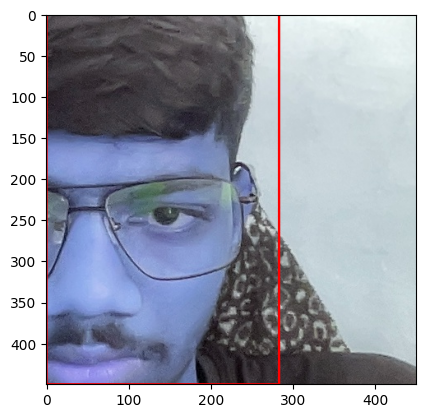

In [27]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### 5.1 Run Augmentation Pipeline

In [8]:

for partition in ['train', 'test', 'val']: 
    for image_name in os.listdir(os.path.join('data', partition, 'images')):
        img_path = os.path.join('data', partition, 'images', image_name)
        img = cv2.imread(img_path)

        # Check if the image is loaded correctly
        if img is None:
            print(f"Failed to read image {image_name}")
            continue

        # Initialize default coordinates
        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image_name.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0] / img.shape[1]  # Normalize to image width
            coords[1] = label['shapes'][0]['points'][0][1] / img.shape[0]  # Normalize to image height
            coords[2] = label['shapes'][0]['points'][1][0] / img.shape[1]  # Normalize to image width
            coords[3] = label['shapes'][0]['points'][1][1] / img.shape[0]  # Normalize to image height

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                augmented_image = augmented['image']
                
                # Save augmented image
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image_name.split(".")[0]}.{x}.jpg'), augmented_image)

                annotation = {}
                annotation['image'] = image_name

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0 

                # Save annotation
                with open(os.path.join('aug_data', partition, 'labels', f'{image_name.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(f"Error processing {image_name}: {e}")


Error processing 1c271aa4-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Failed to read image .DS_Store
Error processing 21df5ba0-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1f2c1fb0-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 2085a8fe-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1fd8dad4-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1bd0dfe0-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 2132bc2e-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1c784492-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1cceed1a-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 1b7a3dc0-70d8-11ef-8135-a6f2f6925d9e.jpg: name 'augmentor' is not defined
Error processing 20dc109a-70d8-11ef-8135-a6f2f6925d9e.jpg: 

### 5.2 Load Augmented Images to Tensorflow Dataset

In [11]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [12]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [13]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [14]:
train_images.as_numpy_iterator().next()

array([[[0.9954044 , 0.9699142 , 0.9243873 ],
        [0.9783701 , 0.9583946 , 0.91311276],
        [0.9463848 , 0.9370711 , 0.894424  ],
        ...,
        [0.37199754, 0.340625  , 0.33278185],
        [0.38045344, 0.3602941 , 0.34528187],
        [0.4393995 , 0.41243872, 0.39920342]],

       [[0.9427696 , 0.9275735 , 0.8854167 ],
        [0.8108456 , 0.79509807, 0.75398284],
        [0.8448529 , 0.83210784, 0.80514705],
        ...,
        [0.40294117, 0.37156862, 0.36372548],
        [0.51262254, 0.48125   , 0.4699755 ],
        [0.46960783, 0.44209558, 0.43118873]],

       [[0.6422794 , 0.62757355, 0.6041667 ],
        [0.65949756, 0.6398897 , 0.62420344],
        [0.53707105, 0.5174632 , 0.50177693],
        ...,
        [0.453799  , 0.42242646, 0.41066176],
        [0.49442402, 0.46305147, 0.45128676],
        [0.46905637, 0.43278188, 0.42346814]],

       ...,

       [[0.35741422, 0.33780637, 0.3221201 ],
        [0.31170344, 0.2920956 , 0.2803309 ],
        [0.30778188, 0

### 6.1 Build Label Loading Function

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.518, 0.   , 1.   , 1.   ], dtype=float16))

### 7.1 Check Partition Lengths

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1260, 1260, 360, 360, 180, 180)

### 7.2 Create Final Datasets (Images/Labels)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2400)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(720)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(360)
val = val.batch(8)
val = val.prefetch(4)

In [24]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.58   , 0.75   , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.2415 , 0.945  ],
        [0.     , 0.02112, 0.671  , 1.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [25]:
data_samples = train.as_numpy_iterator()

In [26]:
res = data_samples.next()
res

(array([[[[0.54295343, 0.38026962, 0.34001225],
          [0.5541054 , 0.3841299 , 0.33970588],
          [0.5761642 , 0.39430147, 0.34773284],
          ...,
          [0.78792894, 0.7918505 , 0.73694855],
          [0.79865193, 0.7913603 , 0.7372549 ],
          [0.79901963, 0.78811276, 0.7375613 ]],
 
         [[0.45655638, 0.30851716, 0.28351715],
          [0.48621324, 0.3278799 , 0.29601717],
          [0.5753676 , 0.40281862, 0.35281864],
          ...,
          [0.7982843 , 0.80220586, 0.73946077],
          [0.79767156, 0.8015931 , 0.73884803],
          [0.8096201 , 0.80710787, 0.7514093 ]],
 
         [[0.45349264, 0.28376225, 0.2528186 ],
          [0.50894606, 0.32867646, 0.2791054 ],
          [0.5966299 , 0.40551472, 0.35067403],
          ...,
          [0.78137255, 0.7852941 , 0.722549  ],
          [0.7970588 , 0.8009804 , 0.7382353 ],
          [0.7959559 , 0.79987746, 0.7420343 ]],
 
         ...,
 
         [[0.50171566, 0.5095588 , 0.48995098],
          [0.56832

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


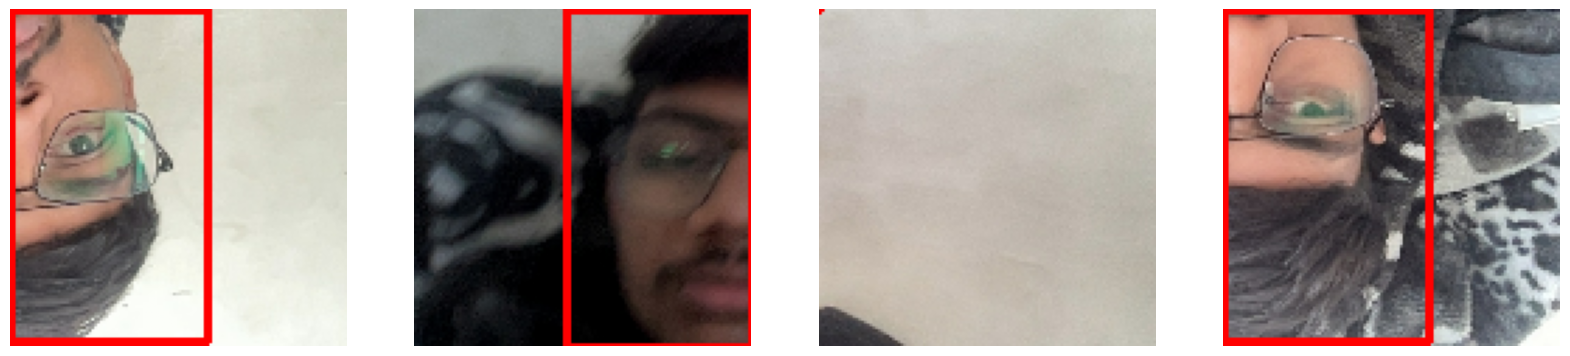

In [27]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = np.copy(res[0][idx])  # Create a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Convert coordinates to integer pixel values
    top_left = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))
    
    # Draw rectangle on the image
    cv2.rectangle(sample_image, top_left, bottom_right, (255, 0, 0), 2)

    # Display image using matplotlib
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide axis for better visualization

plt.show()


### 8.1 Import Layers and Base Network

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [49]:
import requests
response = requests.get('https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
print(response.status_code)


200


In [29]:
vgg = VGG16(include_top=False) 


In [30]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [31]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [32]:
facetracker = build_model()

In [33]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
X, y = train.as_numpy_iterator().next()

In [35]:
X.shape

(8, 120, 120, 3)

In [36]:
classes, coords = facetracker.predict(X)

2024-09-13 16:52:47.780959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


In [37]:
classes, coords

(array([[0.47200528],
        [0.5475677 ],
        [0.62276846],
        [0.52951235],
        [0.5396348 ],
        [0.5553024 ],
        [0.5811992 ],
        [0.53551215]], dtype=float32),
 array([[0.38057104, 0.35997617, 0.66952735, 0.463763  ],
        [0.5135793 , 0.4842646 , 0.5866195 , 0.56080353],
        [0.39654058, 0.35368592, 0.6364354 , 0.54242265],
        [0.4933188 , 0.4880762 , 0.55499077, 0.55850166],
        [0.47424582, 0.46443436, 0.60040367, 0.54675597],
        [0.4993842 , 0.38958618, 0.6584185 , 0.4975864 ],
        [0.44720802, 0.47297633, 0.6261182 , 0.54962856],
        [0.48667732, 0.48636526, 0.5534909 , 0.5597604 ]], dtype=float32))

### 9.1 Define Optimizer and LR

In [38]:

batches_per_epoch = len(train)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=0.75,
    staircase=True
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [40]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [41]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [42]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.5129833>

In [43]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6778607>

In [44]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.5129833>

### 10.1 Create Custom Model Class

In [59]:

class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            # Print shapes for debugging
            # print(f"Shape of y[0]: {y[0].shape}")
            # print(f"Shape of classes: {classes.shape}")
            # print(f"Shape of y[1]: {y[1].shape}")
            # print(f"Shape of coords: {coords.shape}")
            
            if y[0].shape != classes.shape:
                raise ValueError("Shape mismatch between y_true and predictions (classes).")
            if y[1].shape != coords.shape:
                raise ValueError("Shape mismatch between y_true and predictions (coords).")
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
        grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        # Print shapes for debugging
        # print(f"Shape of y[0]: {y[0].shape}")
        # print(f"Shape of classes: {classes.shape}")
        # print(f"Shape of y[1]: {y[1].shape}")
        # print(f"Shape of coords: {coords.shape}")
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [60]:
model = FaceTracker(facetracker)

In [61]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [62]:
logdir='logs'

In [63]:


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


In [64]:
tf.config.run_functions_eagerly(True)


In [65]:
hist = model.fit(train, epochs=10, validation_data=val)


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 108s 665ms/step - class_loss: 0.2096 - regress_loss: 1.0526 - total_loss: 1.1575 - val_class_loss: 0.1654 - val_regress_loss: 0.2599 - val_total_loss: 0.3426
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 120s 746ms/step - class_loss: 0.1201 - regress_loss: 0.5535 - total_loss: 0.6136 - val_class_loss: 0.3312 - val_regress_loss: 0.2974 - val_total_loss: 0.4630
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 113s 700ms/step - class_loss: 0.1030 - regress_loss: 0.3911 - total_loss: 0.4426 - val_class_loss: 0.0165 - val_regress_loss: 0.1683 - val_total_loss: 0.1765
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 111s 689ms/step - class_loss: 0.0822 - regress_loss: 0.3337 - total_loss: 0.3748 - val_class_loss: 8.4949e-04 - val_regress_loss: 0.1294 - val_total_loss: 0.1298
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 110s 684ms/step - class_loss: 0.0715 - regress_loss: 0.2630 - total_loss: 0.2988 - val_class_loss: 0.0245 - val_regress_loss: 0.0845 - val_total_loss: 0.0967
Epoch 

### 10.3 Plot Performance

In [2]:
hist.history

NameError: name 'hist' is not defined

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

NameError: name 'plt' is not defined

### 11.1 Make Predictions on Test Set

In [69]:
test_data = test.as_numpy_iterator()

In [70]:
test_sample = test_data.next()

In [71]:
yhat = facetracker.predict(test_sample[0])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


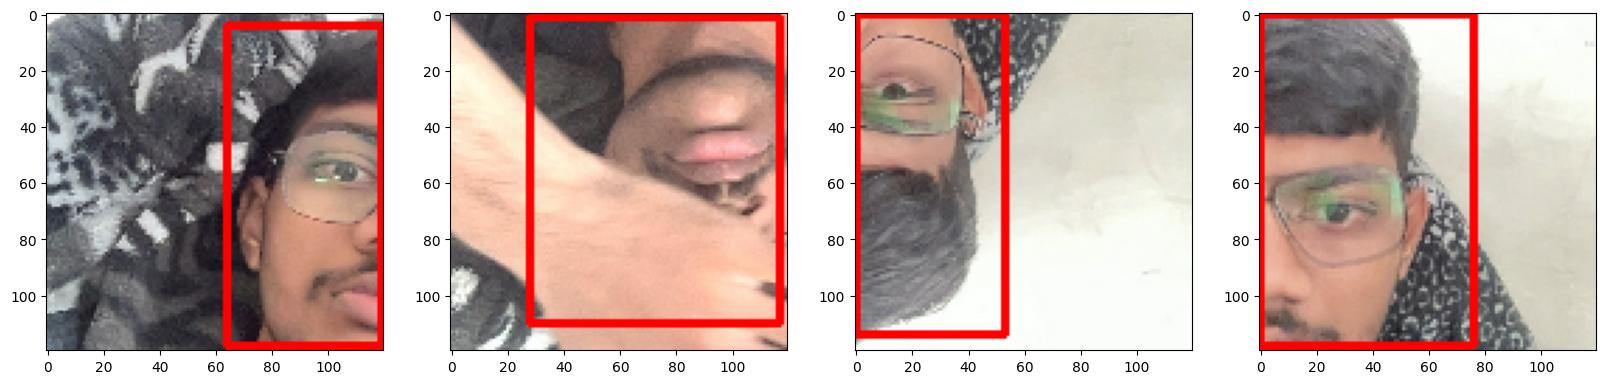

In [72]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # Create a writable copy of the image for modification
    sample_image_copy = sample_image.copy()

    # Draw the rectangle if the condition is met
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_copy, 
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                      (255, 0, 0), 2)

    # Display the modified image
    ax[idx].imshow(sample_image_copy)

# Show the plot
plt.show()


### 11.2 Save the Model

In [4]:
from tensorflow.keras.models import load_model

In [5]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [6]:
facetracker = load_model('facetracker.h5')

2024-09-13 20:56:38.913082: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-13 20:56:38.913127: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-13 20:56:38.913146: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-13 20:56:38.913171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 20:56:38.913189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 11.3 Real Time Detection

In [7]:

# Initialize the video capture object
cap = cv2.VideoCapture(0)  # Try 0, 1, 2... depending on your device

if not cap.isOpened():
    print("Error: Could not open camera.")
else:
    while cap.isOpened():
        _, frame = cap.read()
        
        # Check if frame is successfully captured
        if frame is None:
            print("Error: Failed to capture frame.")
            break
        
        frame = frame[50:500, 50:500, :]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = tf.image.resize(rgb, (120, 120))
        
        yhat = facetracker.predict(np.expand_dims(resized/255, 0))
        sample_coords = yhat[1][0]
        
        if yhat[0] > 0.5:
            cv2.rectangle(frame,
                          tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                          (255, 0, 0), 2)
            cv2.rectangle(frame,
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [80, 0])),
                          (255, 0, 0), -1)
            cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('FaceTrack', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


NameError: name 'cv2' is not defined